# Hands-on Exercise — Neural Network Classification with LSS Power Spectra P(k)

In this exercise you will train a neural network to classify two cosmological models
based on **simulated matter power spectra** \(P(k)\).

We will simulate two classes:

- **Class 0**: baseline ΛCDM-like \(P(k)\)
- **Class 1**: modified \(P(k)\) with a feature/suppression/oscillation

Your tasks:

✅ Generate the dataset  
✅ Normalize inputs  
✅ Train a neural network classifier  
✅ Evaluate with learning curves + confusion matrix  
✅ Improve accuracy by changing one element (architecture)

This notebook is designed for a live session: it should run fast on CPU.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

rng = np.random.default_rng(0)
tf.random.set_seed(0)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Background (physics)

In large-scale structure, the **matter power spectrum** \(P(k)\) encodes how matter is distributed across scales.

- Large \(k\) = small scales
- Small \(k\) = large scales

Different cosmologies can change the *shape* of \(P(k)\), for example:
- changes in tilt,
- small-scale suppression,
- oscillatory features,
- baryon acoustic oscillation patterns (BAO).

Here we build a toy version of this idea:

We generate vectors \(P(k)\) sampled on a grid of \(k\) values,
then train a neural network to classify the model.


In [2]:
# k grid (log-spaced)
k = np.logspace(-3, 0, 200)  # from 1e-3 to 1

def pk_baseline(k, A=1.0, ns=0.96, k_damp=0.4):
    """
    Toy ΛCDM-like matter power spectrum:
    - power-law tilt with ns
    - exponential small-scale damping
    """
    pk = A * (k ** ns) * np.exp(-(k / k_damp)**2)
    return pk

def pk_feature_model(k, A=1.0, ns=0.96, k_damp=0.4,
                     amp=0.2, k0=0.1, width=0.05, freq=70):
    """
    Toy "feature model": baseline P(k) times a localized oscillatory feature.
    """
    pk0 = pk_baseline(k, A=A, ns=ns, k_damp=k_damp)
    bump = np.exp(-0.5*((k - k0)/width)**2) * np.sin(freq*(k-k0))
    return pk0 * (1.0 + amp*bump)


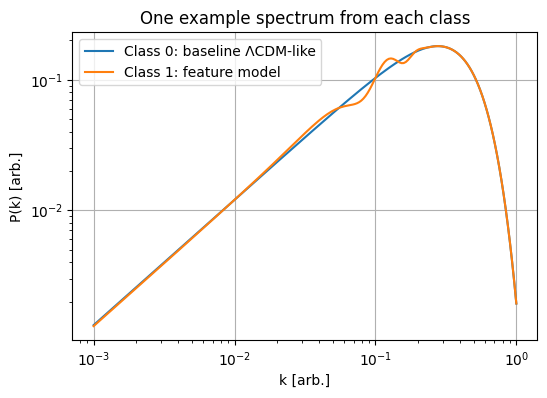

In [3]:
pk0 = pk_baseline(k)
pk1 = pk_feature_model(k)

plt.plot(k, pk0, label="Class 0: baseline ΛCDM-like")
plt.plot(k, pk1, label="Class 1: feature model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k [arb.]")
plt.ylabel("P(k) [arb.]")
plt.title("One example spectrum from each class")
plt.legend()
plt.show()


In [4]:
def generate_dataset(N=3000, noise_frac=0.05):
    X, y = [], []
    
    for i in range(N):
        # small baseline parameter variations
        A = rng.uniform(0.9, 1.1)
        ns = rng.uniform(0.92, 1.0)
        k_damp = rng.uniform(0.3, 0.6)

        if rng.random() < 0.5:
            pk = pk_baseline(k, A=A, ns=ns, k_damp=k_damp)
            label = 0
        else:
            amp = rng.uniform(0.15, 0.3)
            k0 = rng.uniform(0.06, 0.18)
            width = rng.uniform(0.02, 0.06)
            freq = rng.uniform(40, 90)

            pk = pk_feature_model(k, A=A, ns=ns, k_damp=k_damp,
                                  amp=amp, k0=k0, width=width, freq=freq)
            label = 1
        
        # multiplicative noise
        pk_obs = pk * (1.0 + rng.normal(0.0, noise_frac, size=pk.size))
        
        # log transform to compress dynamic range
        X.append(np.log(pk_obs + 1e-12))
        y.append(label)
        
    return np.array(X), np.array(y)

X, y = generate_dataset(N=3000, noise_frac=0.05)
print("X shape:", X.shape)
print("Class counts:", np.unique(y, return_counts=True))

X shape: (3000, 200)
Class counts: (array([0, 1]), array([1504, 1496]))


## 2. Exercise Tasks

### ✅ Task 1:
Split the dataset into train and validation sets.

### ✅ Task 2:
Build and train a neural network classifier.

Suggested architecture:

- Dense(64, relu)
- Dense(64, relu)
- Dense(1, sigmoid)

Train for 40 epochs.

### ✅ Task 3:
Evaluate the learning curves, plot ROC, AUC and the confusion matrix.

### ✅ Task 4 (important):
Normalize the inputs using `StandardScaler` and retrain the model, what happens?

In [15]:
#TO DO 1: train/validation split (use stratify)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

#TO DO 2: standardize
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

print("Train:", X_train_s.shape, "Val:", X_val_s.shape)

Train: (2250, 200) Val: (750, 200)


In [16]:
import tensorflow as tf
tf.keras.backend.clear_session()  #Clear previous models from memory

In [17]:
#TO DO 3: define the model
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#TO DO 4: train
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    batch_size=64,
    verbose=1
)

print("Final train acc:", history.history["accuracy"][-1])
print("Final val acc:", history.history["val_accuracy"][-1])


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6693 - loss: 0.6307 - val_accuracy: 0.7693 - val_loss: 0.5344
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8387 - loss: 0.4407 - val_accuracy: 0.8787 - val_loss: 0.3795
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9124 - loss: 0.2833 - val_accuracy: 0.9293 - val_loss: 0.2475
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.9587 - loss: 0.1682 - val_accuracy: 0.9493 - val_loss: 0.1608
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9760 - loss: 0.1049 - val_accuracy: 0.9653 - val_loss: 0.1148
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9840 - loss: 0.0679 - val_accuracy: 0.9773 - val_loss: 0.0859
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9920 - loss: 0.0464 - val_accuracy: 0.9813 - val_loss: 0.0688
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9956 - loss: 0.0340 - val_accuracy: 0.9840 - val_loss: 0

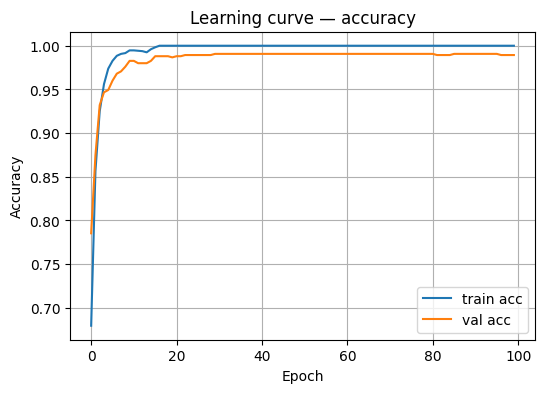

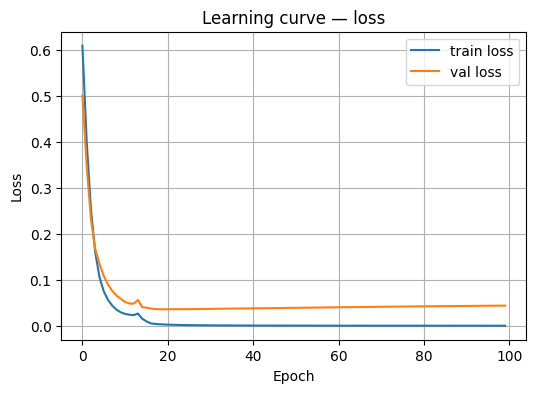

In [8]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning curve — accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve — loss")
plt.legend()
plt.show()


Validation accuracy: 0.989


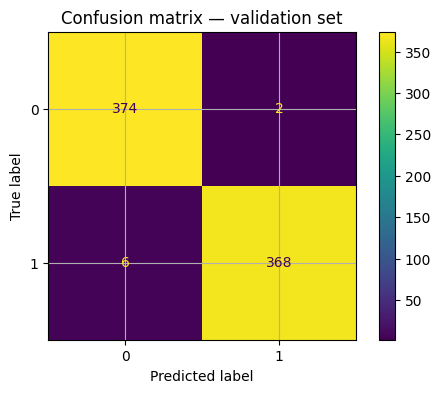

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def predict_labels(model, X):
    proba = model.predict(X, verbose=0)
    return (proba > 0.5).astype(int).ravel()

y_val_pred = predict_labels(model, X_val_s)

acc_val = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {acc_val:.3f}")

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix — validation set")
plt.show()


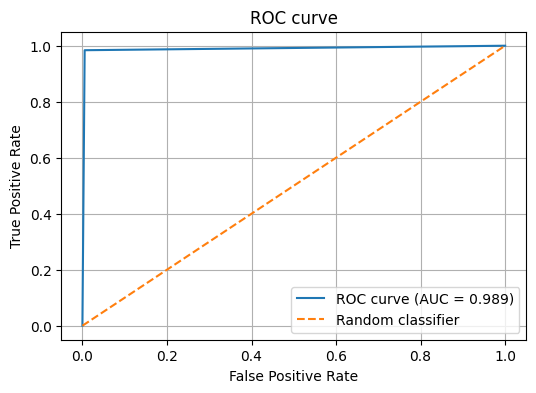

AUC: 0.9893190351575833


In [10]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_pred)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

print("AUC:", auc)

In [ ]:
import optuna

def objective(trial):
    #Hyperparameters to tune
    n1 = trial.suggest_int("n1", 16, 128, step=16)
    n2 = trial.suggest_int("n2", 16, 128, step=16)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = Sequential([
        Dense(n1, activation="relu", input_shape=(X_train_s.shape[1],)),
        Dense(n2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    #Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    #Return best validation accuracy achieved during training
    return max(history.history["val_accuracy"])


In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

print("Best trial:", study.best_trial.params)
print("Best val accuracy:", study.best_value)


[I 2026-01-15 13:35:23,392] A new study created in memory with name: no-name-69da78af-c08f-447f-af6b-cbe6d721ce94
[I 2026-01-15 13:35:27,714] Trial 0 finished with value: 0.7013333439826965 and parameters: {'n1': 32, 'n2': 48, 'lr': 0.0004950297956829944, 'batch_size': 64}. Best is trial 0 with value: 0.7013333439826965.
[I 2026-01-15 13:35:31,526] Trial 1 finished with value: 0.7039999961853027 and parameters: {'n1': 128, 'n2': 80, 'lr': 0.00028932641072164367, 'batch_size': 128}. Best is trial 1 with value: 0.7039999961853027.
[I 2026-01-15 13:35:33,035] Trial 2 finished with value: 0.5360000133514404 and parameters: {'n1': 80, 'n2': 128, 'lr': 0.0008652423434377551, 'batch_size': 64}. Best is trial 1 with value: 0.7039999961853027.
[I 2026-01-15 13:35:35,063] Trial 3 finished with value: 0.6186666488647461 and parameters: {'n1': 112, 'n2': 112, 'lr': 0.0008583030286776342, 'batch_size': 64}. Best is trial 1 with value: 0.7039999961853027.
[I 2026-01-15 13:35:39,064] Trial 4 finished

Best trial: {'n1': 80, 'n2': 48, 'lr': 0.00013520976227790758, 'batch_size': 128}
Best val accuracy: 0.7546666860580444
